In [1]:
import numpy as np
import pandas as pd
from math import sqrt

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split,cross_val_score,cross_validate
from sklearn.model_selection import TimeSeriesSplit

from sklearn import linear_model
from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV 




In [2]:
# Import datasets
returns = pd.read_excel("/Users/alkanpamukcu/Desktop/big data/Returns_Clean.xlsx", index_col = 'Dates')
returns.index = pd.to_datetime(returns.index, format='%Y%m%d')
flows = pd.read_excel("/Users/alkanpamukcu/Desktop/big data/Flows_Clean.xlsx", index_col = 'Dates')
flows.index = pd.to_datetime(flows.index, format='%Y%m%d')
print(returns.head())
print(flows.head())
print(len(returns))

               55976     41072     27748     75259     40970     62519  \
Dates                                                                    
1993-04-01 -0.019685  0.019391 -0.007282 -0.003891  0.083333  0.027027   
1993-04-02 -0.020080  0.002717 -0.002445  0.058594 -0.038462 -0.026316   
1993-04-05 -0.024590 -0.006775 -0.002451  0.022140 -0.040000  0.027027   
1993-04-06 -0.067227  0.009550 -0.007371  0.025271  0.041667  0.052632   
1993-04-07  0.000000  0.005405  0.000000  0.021127  0.040000 -0.050000   

               21792     54084     55511     10302  ...     63829     44986  \
Dates                                               ...                       
1993-04-01  0.005348  0.020000 -0.010417 -0.025000  ...  0.108108 -0.019048   
1993-04-02 -0.007979 -0.019608 -0.021053 -0.025641  ...  0.000000 -0.016181   
1993-04-05  0.005362  0.000000  0.021505  0.026316  ... -0.048780 -0.003289   
1993-04-06  0.005333  0.000000  0.000000  0.038462  ... -0.025641 -0.023102   
1993-04

In [87]:
# add skewness of return as a predictor variable
from scipy.stats import skew 
from scipy.stats import kurtosis
returns[returns.columns[0]]
n=50

for i in range(len(returns.columns)):
    returns['skewness_{}'.format(returns.columns[i])] = returns[returns.columns[i]].rolling(window=n).skew()
    

In [11]:
for j in range(len(returns.columns[:100])):
    returns['momentum_20_50_{}'.format(returns.columns[j])] = np.zeros(shape=(1958,1))
    returns['momentum_8_20_{}'.format(returns.columns[j])] = np.zeros(shape=(1958,1))
    for i in range(49, len(returns[returns.columns[j]])):
        if returns[returns.columns[j]][i-19:i+1].mean() > returns[returns.columns[j]][i-49:i+1].mean():
            returns['momentum_20_50_{}'.format(returns.columns[j])][i] = 1
        if returns[returns.columns[j]][i-19:i+1].mean() < returns[returns.columns[j]][i-49:i+1].mean():
            returns['momentum_20_50_{}'.format(returns.columns[j])][i] = 0
        if returns[returns.columns[j]][i-7:i+1].mean() > returns[returns.columns[j]][i-19:i+1].mean():
            returns['momentum_8_20_{}'.format(returns.columns[j])][i] = 1
        if returns[returns.columns[j]][i-7:i+1].mean() < returns[returns.columns[j]][i-19:i+1].mean():
            returns['momentum_8_20_{}'.format(returns.columns[j])][i] = 0

In [289]:
returns['momentum_20_50_55976']

Dates
1993-04-01    0.0
1993-04-02    0.0
1993-04-05    0.0
1993-04-06    0.0
1993-04-07    0.0
             ... 
2000-12-22    1.0
2000-12-26    0.0
2000-12-27    1.0
2000-12-28    0.0
2000-12-29    0.0
Name: momentum_20_50_55976, Length: 1958, dtype: float64

In [291]:
returns['momentum_20_50_55976']

Dates
1993-04-01    0.0
1993-04-02    0.0
1993-04-05    0.0
1993-04-06    0.0
1993-04-07    0.0
             ... 
2000-12-22    1.0
2000-12-26    0.0
2000-12-27    1.0
2000-12-28    0.0
2000-12-29    0.0
Name: momentum_20_50_55976, Length: 1958, dtype: float64

In [99]:
n=50
for j in range(len(returns.columns[:100])):
    returns['distbottom_{}'.format(returns.columns[j])] = np.zeros(shape=(1958,1))
    returns['disttop_{}'.format(returns.columns[j])] = np.zeros(shape=(1958,1))
    returns['cumulative_{}'.format(returns.columns[j])] = np.cumprod(1 + returns[returns.columns[j]].values)
    for i in range(49, len(returns[returns.columns[j]])):
        returns['distbottom_{}'.format(returns.columns[j])][i] = (returns['cumulative_{}'.format(returns.columns[j])][i]- returns['cumulative_{}'.format(returns.columns[j])][i-n+1:i+1].min()) /returns['cumulative_{}'.format(returns.columns[j])][i]
        returns['disttop_{}'.format(returns.columns[j])][i] = (returns['cumulative_{}'.format(returns.columns[j])][i-n+1:i+1].max()- returns['cumulative_{}'.format(returns.columns[j])][i])/returns['cumulative_{}'.format(returns.columns[j])][i]


In [13]:
def rsi(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n
    
        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return rsi

In [14]:
for j in range(len(returns.columns[:100])):
    returns['rsi_{}'.format(returns.columns[j])] = np.zeros(shape=(1958,1))
    returns['rsi_{}'.format(returns.columns[j])] = rsi(returns['cumulative_{}'.format(returns.columns[j])])
        

In [189]:
for j in range(len(returns.columns[:100])):
    returns['rsi_change_{}'.format(returns.columns[j])] = np.zeros(shape=(1958,1))
    returns['rsi_change_{}'.format(returns.columns[j])] = returns['rsi_{}'.format(returns.columns[j])].pct_change()

In [19]:
for j in range(len(returns.columns[:100])):
    returns['macd_rsi_{}'.format(returns.columns[j])] = np.zeros(shape=(1958,1))
    for i in range(25, len(returns[returns.columns[j]])):
        if returns['rsi_{}'.format(returns.columns[j])][i-11:i+1].mean() > returns['rsi_{}'.format(returns.columns[j])][i-25:i+1].mean():
            returns['macd_rsi_{}'.format(returns.columns[j])][i] = 1
        if returns['rsi_{}'.format(returns.columns[j])][i-11:i+1].mean() < returns['rsi_{}'.format(returns.columns[j])][i-22:i+1].mean():
            returns['macd_rsi_{}'.format(returns.columns[j])][i] = 0


In [20]:
def stochastic(prices, n=14):
    stochastic = np.zeros(shape=(1958,1))
    for i in range(n, len(prices)):
        stochastic[i] = ((prices[i]-prices[i-n:i].min())/(prices[i-n:i].max()-prices[i-n:i].min()))*100
    return stochastic

In [21]:
for j in range(len(returns.columns[:100])):
    returns['stochastic_{}'.format(returns.columns[j])] = np.zeros(shape=(1958,1))
    returns['stochastic_{}'.format(returns.columns[j])] = stochastic(returns['cumulative_{}'.format(returns.columns[j])])

<ipython-input-20-a6053d53f22a>:4: RuntimeWarning: invalid value encountered in double_scalars
  stochastic[i] = ((prices[i]-prices[i-n:i].min())/(prices[i-n:i].max()-prices[i-n:i].min()))*100
<ipython-input-20-a6053d53f22a>:4: RuntimeWarning: divide by zero encountered in double_scalars
  stochastic[i] = ((prices[i]-prices[i-n:i].min())/(prices[i-n:i].max()-prices[i-n:i].min()))*100


In [68]:
for j in range(len(returns.columns[:100])):
    returns['flow_times_return_{}'.format(flows.columns[j])] = np.zeros(shape=(1958,1))
    returns['5dayflow_times_return_{}'.format(flows.columns[j])] = np.zeros(shape=(1958,1))
    for i in range(4, len(returns[returns.columns[j]])):
        returns['flow_times_return_{}'.format(flows.columns[j])][i] = returns[returns.columns[j]][i] * flows[returns.columns[j]][i]
        returns['5dayflow_times_return_{}'.format(flows.columns[j])][i] = returns[returns.columns[j]][i-4:i+1].mean() * flows[returns.columns[j]][i-4:i+1].sum()  

In [103]:
for j in range(len(returns.columns[:100])):
    returns['dist_top_band_{}'.format(flows.columns[j])] = np.zeros(shape=(1958,1))
    returns['dist_bottom_band_{}'.format(flows.columns[j])] = np.zeros(shape=(1958,1))
    for i in range(19, len(returns[returns.columns[j]])):
        std = returns['cumulative_{}'.format(returns.columns[j])][i-19:i+1].std()
        mean = returns['cumulative_{}'.format(returns.columns[j])][i-19:i+1].mean()
        bollinger_top = mean + 2*std
        bollinger_bottom = mean - 2*std
        returns['dist_top_band_{}'.format(flows.columns[j])][i] = (bollinger_top - returns['cumulative_{}'.format(returns.columns[j])][i])/returns['cumulative_{}'.format(returns.columns[j])][i]
        returns['dist_bottom_band_{}'.format(flows.columns[j])][i] = (returns['cumulative_{}'.format(returns.columns[j])][i] - bollinger_bottom)/returns['cumulative_{}'.format(returns.columns[j])][i]

In [28]:
def difference_from_mean(prices, n=50):
    difference = np.zeros(shape=(1958,1))
    for i in range(n, len(prices)):
        difference[i] = prices[i] - prices[i-n:i].mean()
    return difference

In [29]:
for j in range(len(returns.columns[:100])):
    returns['difference_from_mean_{}'.format(returns.columns[j])] = np.zeros(shape=(1958,1))
    returns['difference_from_mean_{}'.format(returns.columns[j])] = difference_from_mean(returns[returns.columns[j]])

In [32]:
for j in range(len(returns.columns[:100])):
    returns['lag1_{}'.format(returns.columns[j])] = returns[returns.columns[j]].shift(1)
    returns['lag2_{}'.format(returns.columns[j])] = returns[returns.columns[j]].shift(2)
    returns['lag3_{}'.format(returns.columns[j])] = returns[returns.columns[j]].shift(3)
    

In [268]:
from ta import add_all_ta_features
from ta.utils import dropna

In [308]:
# since I will use the variables starting from the 50th index
# and will use lagged values of them, i decided to take it starting from 49th index
# since there will be NA values after the lag, when i delete the NA values, my index will be starting from 50
df = returns.iloc[49:,]

In [300]:
g = globals()

In [315]:
for j in returns.columns[:100]:
    # add the lagged values of variables for prediction
    g['df_{}'.format(j)] = pd.DataFrame([])
    g['df_{}'.format(j)]['skewness'] = df['skewness_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['momentum_20_50'] = df['momentum_20_50_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['momentum_8_20'] = df['momentum_8_20_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['distbottom'] = df['distbottom_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['disttop'] = df['disttop_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['rsi'] = df['rsi_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['rsi_change'] = df['rsi_change_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['macd_rsi'] = df['macd_rsi_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['stochastic'] = df['stochastic_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['flow_times_return'] = df['flow_times_return_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['5dayflow_times_return'] = df['5dayflow_times_return_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['dist_top_band'] = df['dist_top_band_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['dist_bottom_band'] = df['dist_bottom_band_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['difference_from_mean'] = df['difference_from_mean_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['flows'] = flows[j].shift(1)[1:]
    
    #add the lags without shifting, because they are already lagged values
    g['df_{}'.format(j)]['lag1_{}'.format(j)] = df['lag1_{}'.format(j)][1:]
    g['df_{}'.format(j)]['lag2_{}'.format(j)] = df['lag2_{}'.format(j)][1:]
    g['df_{}'.format(j)]['lag3_{}'.format(j)] = df['lag3_{}'.format(j)][1:]
    
    g['df_{}'.format(j)]['ret_class'] = np.zeros(shape=(len(g['df_{}'.format(j)]),1))
    for i in range(len(g['df_{}'.format(j)]['ret_class'])):
        if df[j][i] < -0.02:
            g['df_{}'.format(j)]['ret_class'][i] = -1
        elif df[j][i] > 0.02: 
            g['df_{}'.format(j)]['ret_class'][i] = 1
        else:
            g['df_{}'.format(j)]['ret_class'][i] = 0
            

In [320]:
for j in returns.columns[:100]:
    columns = list(returns.columns[:100])
    columns.remove(j)
    others = columns
    for k in others:
        g['df_{}'.format(j)]['lag1_{}'.format(k)] = g['df_{}'.format(k)]['lag1_{}'.format(k)]
        g['df_{}'.format(j)]['lag2_{}'.format(k)] = g['df_{}'.format(k)]['lag2_{}'.format(k)]
        g['df_{}'.format(j)]['lag3_{}'.format(k)] = g['df_{}'.format(k)]['lag3_{}'.format(k)]

In [328]:
# Preprocessing the datasets

# the combine of returns and flows of stocks
S = df_55976
# print(S.describe())

# Standardize the dataset
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(S), columns = S.columns)


In [157]:
# I DIDNT USE THISS!!!!!!








# Function that generates predictor matrix for individual stock i 
# inputs: stock i, r_i, f_i, and full datasets S. 
# outputs: 
# predictor matrix X_small, includes stock i’s own returns up to three lags and stock i’s net trading flows up to three lags
# precictor matrix X_full, full predictor variables matrix by adding lagged cross stock to X_small
# predictor matrix X_alter, full predictor variables not based on X_small
def predictor(i, r_i,f_i, S):
    #     predictor matrix X_small
    X_small = pd.DataFrame()   
    for j in range(1,4):
        r_t = r_i.iloc[:len(r_i)-j]
        f_t = f_i.iloc[:len(f_i)-j]
        X_small = pd.concat([X_small, r_t], axis = 1)
        X_small = pd.concat([X_small, f_t], axis = 1)
    
    #     Add stock i’s lagged cross stock returns and flows to predictor matrix
    lagged_cross_stock = S.iloc[:len(r_i)-1]
    lagged_cross_stock.pop(i)
    
    #     generate full predictor variables matrix by adding lagged cross stock to X_small
    X_full = pd.concat([X_small, lagged_cross_stock], axis = 1)
    X_full.fillna(0, inplace = True)
    #     generate full predictor variables not based on X_small
    X_alter = pd.concat([S[i].iloc[:len(r_i)-1], lagged_cross_stock], axis = 1)
    X_alter.fillna(0, inplace = True)  

    return X_small, X_full, X_alter

In [329]:
# Visualize the Mean squre error on each fold 
# plot the mse & log(alphas) in LASSO model
# inputs: stock index and its LASSO model

def plot_mse(i,LA_model):
    
    # This is to avoid division by zero while doing np.log10
    EPSILON = 1e-4
    # Display results
    m_log_alphas = -np.log10(LA_model.alphas_ + EPSILON)
    # print(m_log_alphas)

    plt.figure()
    plt.plot(m_log_alphas, LA_model.mse_path_, ':')
    plt.plot(m_log_alphas, LA_model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
    plt.axvline(-np.log10(LA_model.alpha_ + EPSILON), linestyle='--', color='k',
            label='alpha: CV estimate')

    plt.legend()

    plt.xlabel('-log(alpha)')
    plt.ylabel('Mean square error')
    plt.title('Mean square error on each fold for stock ' + str(i))
    plt.axis('tight')

In [ ]:
# I DIDNT USE THISSSSS!!!!!!!!!







l = returns.columns[0]
print(l)
#y1 = r_i_t is the variable to predict
y1 = returns[l].iloc[1:]

#predictor matrix X_small
r_l = pd.Series(returns[l], index = returns.index)
f_l = pd.Series(flows[l], index = flows.index)
X1_small, X1_full, X1_alter = predictor(l, r_l, f_l, S)

55976
       R squared
55976   0.487338


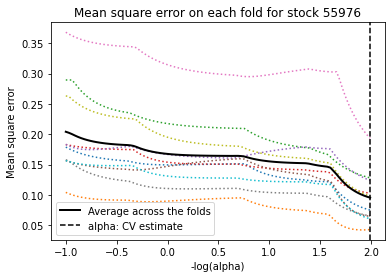

In [331]:

# Using first stock 55976 to demonstrate the process
l = returns.columns[0]
print(l)
#y1 = r_i_t is the variable to predict
y1 = df_55976['ret_class']
predictors = df_55976
X1_full = predictors.drop(['ret_class'], axis=1)


# split the training and test dataset using X_full
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_full, y1, test_size=0.8, random_state=0, shuffle = False)
# print(X1_test.shape)

#     Lasso model with cross-validation of 20-fold
LA_model = LassoCV(fit_intercept = False, max_iter = 100000, tol = 0.0001, cv = 10)

LA_model.fit(X1_train, y1_train)
LA_model.predict(X1_test)
l_score = pd.DataFrame([LA_model.score(X1_test, y1_test)], index = [l], columns = ['R squared'])
# print(LA_model.score(X1_test, y1_test))
print(l_score)
# print(LA_model.coef_)
# print(LA_model.alpha_)
# print(LA_model.alphas_)
plot_mse(l,LA_model)

In [332]:
LASSO_models = []
LASSO_scores = []
LA_mses = []
LA_rmse = []
# print(X.iloc[:len(returns)-1])
for i in tqdm(returns.columns[0:100]):
    if i == 32299:
        continue
#     y = r_i_t is the variable to predict
    y = g['df_{}'.format(i)]['ret_class']
    predictors = g['df_{}'.format(i)]
    X_full = predictors.drop(['ret_class'], axis=1)
    X_full.fillna(0, inplace = True)
        
    
#   split the training and test dataset using X_full
    X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=0, shuffle = False)
    # print(X_test.shape)

#     Lasso model using cross-validation of 20-fold
    LA_model = LassoCV(fit_intercept = False, max_iter = 100000, tol = 0.0001, cv = 20)
    LA_model.fit(X_train, y_train)
#     LA_model.predict(X_test)
    score = {i : LA_model.score(X_test, y_test)}
    LASSO_scores.append(score)
    LASSO_models.append(LA_model)
    y_pred = LA_model.predict(X_test)
    mse = {i : mean_squared_error(y_pred, y_test)}
    sqrt_mse = {i : sqrt(mean_squared_error(y_pred, y_test))}
    LA_mses.append(mse)
    LA_rmse.append(sqrt_mse)

In [333]:
LASSO_alphas = [model.alpha_ for model in LASSO_models]
LASSO_coefs = [model.coef_ for model in LASSO_models]
#print(LASSO_coefs[1])
#print(LASSO_alphas[1])
#print(LASSO_scores)

In [354]:
print(LASSO_coefs[0])

[ 0.         -0.         -0.          0.          0.         -0.00365791
  1.73098732 -0.04192533  0.00360452  0.          0.          0.
  0.          0.          0.03370546  0.         -0.         -0.
  0.          0.         -0.          0.         -0.         -0.
  0.         -0.          0.         -0.         -0.         -0.
  0.         -0.         -0.          0.         -0.         -0.
 -0.         -0.          0.          0.         -0.          0.
  0.         -0.          0.          0.         -0.         -0.
  0.         -0.          0.          0.         -0.         -0.
  0.         -0.         -0.          0.         -0.          0.
  0.         -0.         -0.          0.         -0.         -0.
  0.         -0.         -0.          0.         -0.         -0.
  0.         -0.          0.          0.         -0.          0.
 -0.         -0.         -0.          0.          0.          0.
 -0.         -0.         -0.          0.         -0.          0.
  0.         -0. 

In [225]:
df_55976

,skewness,momentum_20_50,momentum_8_20,distbottom,disttop,rsi,rsi_change,stochastic,flow_times_return,5dayflow_times_return,dist_top_band,dist_bottom_band,difference_from_mean,lag1_55976,lag2_55976,lag3_55976,flows,ret_class
Dates,,,,,,,,,,,,,,,,,,
1993-06-14,-0.413829,1.0,0.0,0.038217,0.128246,46.429200,-0.022072,31.802828,0.001384,-0.002570,0.066154,0.035168,-0.001756,0.028436,-0.009390,0.004717,-0.300324,0.0
1993-06-15,-0.417029,1.0,0.0,0.020070,0.130690,42.397698,-0.086831,6.360202,0.017437,0.000108,0.087202,0.020128,-0.015969,-0.004608,0.028436,-0.009390,-0.941566,0.0
1993-06-16,-0.413715,1.0,0.0,0.000000,0.163623,37.182399,-0.123009,-31.802877,0.160530,0.021355,0.123074,0.000035,-0.025783,-0.018519,-0.004608,0.028436,-5.672035,-1.0
1993-06-17,-0.150465,0.0,1.0,0.004831,0.158002,38.539254,0.036492,4.825391,-0.013577,0.019926,0.118018,0.012832,0.007447,-0.028302,-0.018519,-0.004608,-2.797041,0.0
1993-06-18,-0.104654,0.0,0.0,0.000000,0.192570,33.818775,-0.122485,-24.129635,0.199126,0.250571,0.150414,-0.004321,-0.027834,0.004854,-0.028302,-0.018519,-6.869734,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-22,0.007404,1.0,0.0,0.177200,0.051093,56.105639,0.033507,62.956500,0.051008,0.133416,0.064545,0.098739,0.011240,0.057471,0.020781,-0.050680,3.519515,0.0
2000-12-26,0.073172,0.0,0.0,0.146726,0.090022,50.676778,-0.096761,37.062984,-0.009960,0.013398,0.103035,0.061711,-0.039781,0.014493,0.057471,0.020781,0.278894,-1.0
2000-12-27,0.061629,1.0,1.0,0.178179,0.049842,55.471600,0.094616,66.099508,0.140405,0.241247,0.062225,0.089255,0.035316,-0.035714,0.014493,0.057471,3.668618,1.0


In [ ]:
# I DIDNT TRY IT YET!!!





# Using the equally-weighted portfolio consisting with all 100 stocks to demonstrate the model
# The portfolio returns and flows are the average of all stocks
port_returns = pd.DataFrame(data = returns.mean(axis=1), columns = ['Portfolio_returns'] )
# print(port_returns.head())
port_flows = pd.DataFrame(data = flows.mean(axis = 1), columns = ['Portfolio_flows'])
# port_flows.head()
portfolio = pd.concat([port_returns, port_flows], axis = 1)
# generate predictor matrix for portfolio
# predictor matrix P_small, includes portfolio's own returns up to three lags and portfolio’s net trading flows up to three lags

P_small = pd.DataFrame()   
for j in range(1,4):
    p_t = port_returns.iloc[:len(port_returns)-j]
    f_t = port_flows.iloc[:len(port_flows)-j]
    P_small = pd.concat([P_small, p_t], axis = 1)
    P_small = pd.concat([P_small, f_t], axis = 1)
    
    
#     generate full predictor variables matrix by adding all stock to P_small
P_full = pd.concat([P_small, S], axis = 1)
P_full.fillna(0, inplace = True)

#     generate full predictor variables not based on P_small
P_alter = pd.concat([portfolio , portfolio.iloc[:len(portfolio)-1]], axis = 1)
P_alter.fillna(0, inplace = True)  
# print(P_full)


py = port_returns
# split the training and test dataset using X_full
P_train, P_test, py_train, py_test = train_test_split(P_full, py.values.ravel(), test_size=0.2, random_state=0, shuffle = False)
# print(py.shape)

# rolling window
p_train_size = len(P_train)
# window_size = int(p_train_size/10)
window_size = 200
cumulated_rmse = 0
LASSO_models_p = []
LASSO_scores_p = []
LA_mses_p = []
LA_rmse_p = []
for n in range(1, window_size+1):
    n_train = P_train.iloc[n:n+window_size]
    ny_train = py_train[n:n+window_size]

#     Lasso model with cross-validation of 5-fold
    LA_model = LassoCV(fit_intercept = False, max_iter = 100000, tol = 0.0001, cv = 5)
    LA_model.fit(n_train, ny_train)
    LASSO_models_p.append(LA_model)
    score = LA_model.score(n_train,ny_train)
    LASSO_scores_p.append(score)
#     in-sample rmse
    ny_pred = LA_model.predict(n_train)
    mse = mean_squared_error(ny_pred, ny_train)
    LA_mses_p.append(mse)
    rmse = sqrt(mean_squared_error(ny_pred, ny_train))
    LA_rmse_p.append(rmse)
    
# print(LA_model.coef_)
# print(LA_model.alpha_)
# print(LA_model.alphas_)




In [ ]:
min_rmse = min(LA_rmse_p)
min_index = LA_rmse_p.index(min_rmse)
best_LASSO = LASSO_models_p[min_index]
# out-of-sample rmse
OOS_rmse = sqrt(mean_squared_error(best_LASSO.predict(P_test),py_test))
print(OOS_rmse)
print(best_LASSO.alpha_)
plot_mse('Portfolio',LA_model)